# White Blood Cell Classification

In [10]:
import matplotlib.pyplot as plt 
import tensorflow as tf
import numpy as np
import os
from glob import glob

## Load and explore dataset

In [2]:
DATASET_DIR = "../input/blood-cells-image-dataset/bloodcells_dataset"
CLASS_NAMES = os.listdir(DATASET_DIR)
NUM_CLASSES = len(CLASS_NAMES)

In [3]:
batch_size = 32
epochs = 10
img_height = 32
img_width = 32

In [4]:
# Import image dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Dataset autotune
AUTOTUNE = tf.data.AUTOTUNE
train_ds_tuned = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_tuned = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 17092 files belonging to 8 classes.
Using 13674 files for training.


2022-07-17 13:07:54.103498: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Found 17092 files belonging to 8 classes.
Using 3418 files for validation.


2022-07-17 13:07:57.713853: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


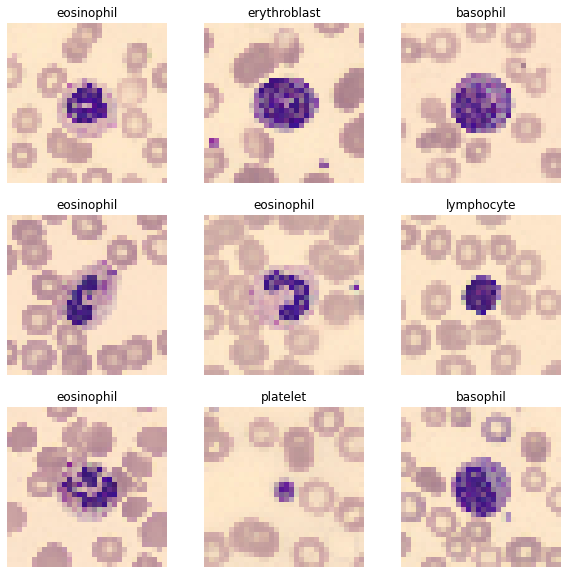

In [5]:
# Show dataset sample
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(CLASS_NAMES[labels[i]])
        plt.axis("off")

## Set up the model 

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES)
    ])

model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)


model.build(input_shape=(0, img_width, img_height, 3))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (0, 32, 32, 3)            0         
_________________________________________________________________
conv2d (Conv2D)              (0, 30, 30, 32)           896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (0, 15, 15, 32)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (0, 13, 13, 32)           9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (0, 6, 6, 32)             0         
_________________________________________________________________
conv2d_2 (Conv2D)            (0, 4, 4, 32)             9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (0, 2, 2, 32)             0

In [7]:
res = model.fit(
  train_ds_tuned,
  validation_data=val_ds_tuned,
  epochs=epochs
)

Epoch 1/10
428/428 [==============================] - 24s 53ms/step - loss: 1.1546 - accuracy: 0.5738 - val_loss: 0.8663 - val_accuracy: 0.6510
Epoch 2/10
428/428 [==============================] - 6s 13ms/step - loss: 0.7062 - accuracy: 0.7355 - val_loss: 0.7035 - val_accuracy: 0.7218
Epoch 3/10
428/428 [==============================] - 6s 14ms/step - loss: 0.5785 - accuracy: 0.7799 - val_loss: 0.6136 - val_accuracy: 0.7542
Epoch 4/10
428/428 [==============================] - 6s 14ms/step - loss: 0.4871 - accuracy: 0.8170 - val_loss: 0.4940 - val_accuracy: 0.8110
Epoch 5/10
428/428 [==============================] - 6s 13ms/step - loss: 0.4210 - accuracy: 0.8420 - val_loss: 0.4186 - val_accuracy: 0.8394
Epoch 6/10
428/428 [==============================] - 6s 15ms/step - loss: 0.3704 - accuracy: 0.8621 - val_loss: 0.3634 - val_accuracy: 0.8654
Epoch 7/10
428/428 [==============================] - 5s 13ms/step - loss: 0.3289 - accuracy: 0.8809 - val_loss: 0.3345 - val_accuracy: 0.878

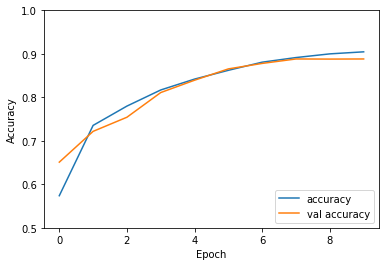

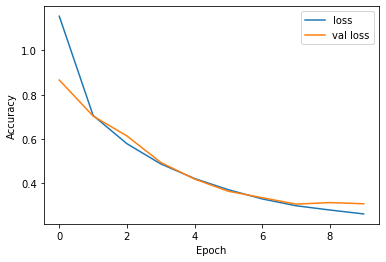

In [8]:
plt.plot(res.history['accuracy'], label="accuracy")
plt.plot(res.history['val_accuracy'], label="val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0.5, 1])
plt.legend(loc="lower right")
plt.show()
plt.plot(res.history['loss'], label="loss")
plt.plot(res.history['val_loss'], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="upper right")
plt.show()

## Make some predictions

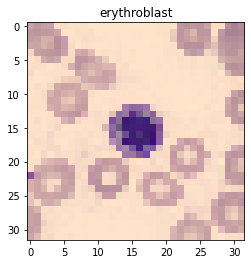

This image most likely belongs to erythroblast with a 98.17 percent confidence.


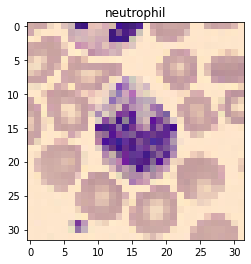

This image most likely belongs to ig with a 71.30 percent confidence.


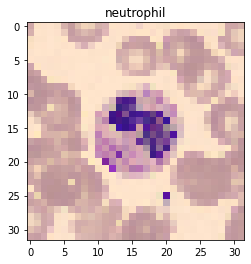

This image most likely belongs to neutrophil with a 100.00 percent confidence.


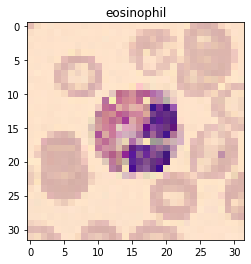

This image most likely belongs to eosinophil with a 99.80 percent confidence.


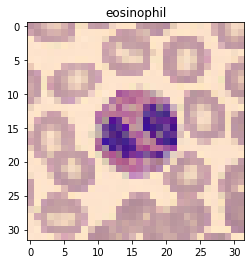

This image most likely belongs to eosinophil with a 98.39 percent confidence.


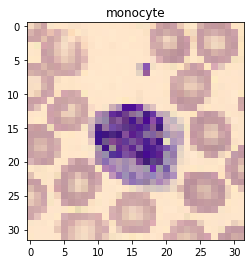

This image most likely belongs to ig with a 66.98 percent confidence.


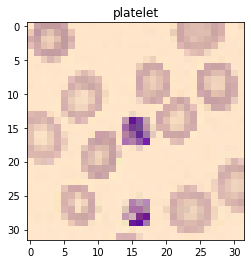

This image most likely belongs to platelet with a 99.95 percent confidence.


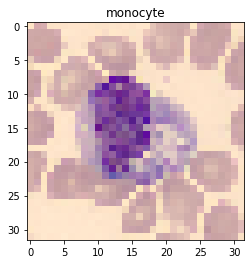

This image most likely belongs to monocyte with a 90.89 percent confidence.


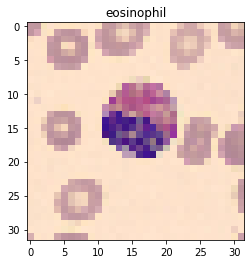

This image most likely belongs to eosinophil with a 83.68 percent confidence.


In [12]:
CLASS_NAMES = train_ds.class_names
imgs = glob(os.path.join(DATASET_DIR, "*/*.jpg"))
tests = 9
for i in range(tests):
    img_path = np.random.choice(imgs)
    
    img = tf.keras.utils.load_img(
        img_path, target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    correct_label = img_path.split("/")[-2]
    plt.imshow(img)
    plt.title(correct_label)
    plt.show()
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(CLASS_NAMES[np.argmax(score)], 100 * np.max(score))
    )